## Unstructured Data - Continued

Picking up where we left off - in this lab we'll use the same book data set that we web scraped. We'll pick a large genre, and see if we can identify some common words for the genre. We'll then see if we can distinguish genre's from each another.

This brings us to the fundamental problem of both data engineering and data science work with unstructured data. That is, in general, computers understand numbers better than words. This sounds obvious, but it is the fundamental problem that has to be solved when extracting information from unstructured data.

This lab will require a bit of handholding, as there are some complex concepts we're going jump into.

Let's get started. . .

In [1]:
#import pandas, nltk, from nltk.tokenize.api import TokenizerI, matplotlib (inline), numpy

import nltk
from nltk.tokenize.api import TokenizerI
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

#import the model_selection class from scikit

from sklearn import model_selection

In [2]:
#read in the book data

data = pd.read_csv('scraped_books.csv', index_col=0)
data.head()

,Title,Price,Description,Rating,Link,Genre
0,A Light in the Attic,Â£51.77,It's hard to imagine a world without A Light i...,Three,a-light-in-the-attic_1000/index.html,Poetry
1,Tipping the Velvet,Â£53.74,"""Erotic and absorbing...Written with starling ...",One,tipping-the-velvet_999/index.html,Historical Fiction
2,Soumission,Â£50.10,"Dans une France assez proche de la nÃ´tre, un ...",One,soumission_998/index.html,Fiction
3,Sharp Objects,Â£47.82,"WICKED above her hipbone, GIRL across her hear...",Four,sharp-objects_997/index.html,Mystery
4,Sapiens: A Brief History of Humankind,Â£54.23,From a renowned historian comes a groundbreaki...,Five,sapiens-a-brief-history-of-humankind_996/index...,History


In [3]:
#display the top 10 genres

data.Genre.value_counts()[:10]

Default           152
Nonfiction        110
Sequential Art     75
Add a comment      67
Fiction            65
Young Adult        54
Fantasy            48
Romance            35
Mystery            32
Food and Drink     30
Name: Genre, dtype: int64

Looks like the top few genres are fairly broad, so let's pick a genre that likely has more descriptive keywords.

In [4]:
#create a slice of the dataframe that is only books in the Fantasy genre and show the first 5 rows of it

fantasy = data[data['Genre'] == 'Fantasy']
fantasy.head()

,Title,Price,Description,Rating,Link,Genre
49,Unicorn Tracks,Â£18.78,After a savage attack drives her from her home...,Three,unicorn-tracks_951/index.html,Fantasy
76,"Saga, Volume 6 (Saga (Collected Editions) #6)",Â£25.02,"After a dramatic time jump, the three-time Eis...",Three,saga-volume-6-saga-collected-editions-6_924/in...,Fantasy
81,Princess Between Worlds (Wide-Awake Princess #5),Â£13.34,Just as Annie and Liam are busy making plans t...,Five,princess-between-worlds-wide-awake-princess-5_...,Fantasy
91,Masks and Shadows,Â£56.40,"The year is 1779, and Carlo Morelli, the most ...",Two,masks-and-shadows_909/index.html,Fantasy
112,Crown of Midnight (Throne of Glass #2),Â£43.29,"""A line that should never be crossed is about ...",Three,crown-of-midnight-throne-of-glass-2_888/index....,Fantasy


## Dipping our toes in. . .

Now let's split this into a training and test set. The idea here is that we want to find common words in 70% of the Fantasy book descriptions. Then we'll see if we can accurately predict the other 30% of the books. There is a very easy way of doing this using scikit-learn's [*sklearn.model_selection.train_test_split()*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. To be totally clear, this is way overkill for this application, but it's a cool way to start using scikit, so let's do it. 😂

In [5]:
#split the dataframe into a train (70%) and test (30%) set

train, test = model_selection.train_test_split(fantasy, test_size=0.3, train_size=0.7, random_state=10)

In [6]:
#check the len of your train set to confirm you split properly

len(train)

33

In [7]:
#check the len of your test set to confirm you split properly

len(test)

15

Now, let's create a tokenization function that you can use apply to each row. It should tokenize the given row's description, remove stopwords, create a FreqDist for the tokens, remove anything that is < 1 character, and then return the top 5 most common words.

In [8]:
#import stopwords and set them to use the english subset

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [9]:
#define the tokenization function 

def common_word_getter(row):
    words = nltk.word_tokenize(row.Description)
    frequency = nltk.FreqDist(words)
    frequency = [(w, f) for (w, f) in frequency.items() if w.lower() not in stopwords]
    frequency = [(w, f) for (w, f) in frequency if len(w) > 1]
    frequency.sort(key=lambda tup: tup[1], reverse=True)
    most_common = frequency[:5]
    return most_common

In [10]:
#create a list of the most common words per book by iterating through the training set and applying your function

common_list = []

for index, row in train.iterrows():
    common_list.extend([i[0] for i in common_word_getter(row)])

In [11]:
#show the top of the common list

common_list[:10]

['since',
 'months',
 'London',
 'four',
 'stone',
 'Peter',
 "'s",
 'Probationary',
 'Constable',
 'Grant']

## Annnnd now we jump straight into the deep end 🤯

Up until this point, we've tokenized bits of text manually, and manually sorted, removed stopwords, etc. The hope here is to build some intuition around the steps required to work with text. Now, we're going to introduce some industry standard tools that do many of these steps together. We'll still go step by step, but these tools will allow us to abstract from some of the 'manual-ness' we've experienced thus far.

In [12]:
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from sklearn.metrics.pairwise import cosine_distances

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances

In [13]:
#instantiate an instance of the CountVectorizer() class

vect = CountVectorizer()
vect

CountVectorizer()

This class is really cool. We'll run it on our Description column, and use it to vectorize each piece of text. The vectorizing here is extremely simple, and is the most basic way of making the 'words to numbers' jump we discussed above.

Essentially, you take every word in the piece of text you're analyzing and replace it with a 1. Then, for each additional instance of the same word, you add 1. We'll go step by step to show what's happening.

In [14]:
#set the stop_words argument equal to the stopwords we defined before, and set max_features to 10

vect = CountVectorizer(stop_words=stopwords, max_features=10)
vect

CountVectorizer(max_features=10,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [15]:
#use vect.fit_transform() on the Description column in the training set to find the vectors of the training data

train_vectors = vect.fit_transform(train.Description)
train_vectors

<33x10 sparse matrix of type '<class 'numpy.int64'>'
	with 107 stored elements in Compressed Sparse Row format>

In [16]:
#get the feature names that sklearn found

vect.get_feature_names()

['book',
 'find',
 'four',
 'life',
 'new',
 'one',
 'power',
 'series',
 'seven',
 'world']

The resulting vector is what's called a 'sparse matrix'. This is a numpy data type for storing large, sparse arrays. The dimensions of the vector are:

- rows = # of samples vectorized
- columns = # of features

Now - here's the really mindblowing part :)

Now that we've defined this 'vect' class, it will 'remember' it's vocabulary the next time we call it. This is because of the object oriented concept called inheritance. [This](https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65) Medium post does a reasonable job at explaining the concept (as applies to sklearn specifically). 

For our purposes, it means that once we've instantiated the class on the training set, we can call it on the test set and it will remember the common words from the training set. This can be a bit confusing, so definitely do some reading on this before moving on.

In [17]:
#repeat the above on the test set

test_vectors = vect.transform(test.Description)
test_vectors

<15x10 sparse matrix of type '<class 'numpy.int64'>'
	with 39 stored elements in Compressed Sparse Row format>

## So now we have two matrices:

- The train vector has the vectorization of the ten most common words throughout the corpus
- The test vector has the vectorization of each of those ten words in the test set 

Now, if our goal is to use these training vectors to predict the genre of our test set, we need some way of comparing these vectors against each other. There are many ways to do this, so we'll start with using the cosine similarity. If you're really interested in understanding what's going on under the hood, read up on it [here.](https://en.wikipedia.org/wiki/Cosine_similarity)

At a high level, what we need to do a few things:

- First, we need to find some measure of 'averageness' across our training vectors. This wil be a single vector that represents the average presence of each term across the training corpus.
- Second, we need to score each of the test vectors against this 'average' vector
- Third, we should look at those scores and see if there is any discernible pattern in them
- Finally, the real test of 'predictiveness' will be to shuffle in some other genres with out test set, score them all against the average vector, and see if we can accurately distinguish the fantasy books from the rest of the data.

Let's go!

In [18]:
#find the average vector in the training set

average_vector = train_vectors.mean(axis=0)
average_vector

matrix([[0.75757576, 0.57575758, 0.54545455, 0.6969697 , 1.12121212,
         0.96969697, 0.57575758, 0.90909091, 0.60606061, 0.93939394]])

In [19]:
#score the test vectors using their cosine distance from the average vector

scores = cosine_distances(X=average_vector, Y=test_vectors)

In [20]:
#show the scores

scores

array([[0.53433771, 0.34467012, 0.7705006 , 0.52428744, 0.398394  ,
        0.41920634, 0.6134747 , 0.6134747 , 0.24644118, 0.22091279,
        0.56605469, 0.62555361, 0.48753501, 0.6134747 , 0.54159191]])

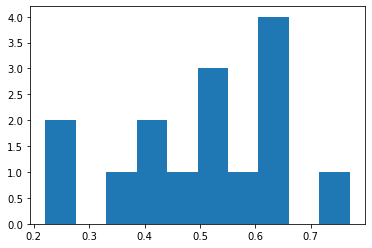

In [21]:
#histogram the scores

plt.hist(scores[0])
plt.show()

In [22]:
#randomly shuffle in 50 rows from the other genres to the test set, and re-run the same prediction steps we ran above
#feel free to also exclude the 'Add a comment' and 'Default' genres, as we don't know what their true genre is

out_of_genre = test.append(data[data['Genre']!='Fantasy'].sample(50))
out_of_genre = out_of_genre[out_of_genre['Genre']!='Default']
out_of_genre = out_of_genre[out_of_genre['Genre']!='Add a comment']

In [23]:
#run the shuffled data through the vect class

out_of_genre_vects = vect.transform(out_of_genre.Description)
out_of_genre_vects

<48x10 sparse matrix of type '<class 'numpy.int64'>'
	with 95 stored elements in Compressed Sparse Row format>

In [24]:
#score these out of genre vectors against the average vector we created above

out_of_genre_scores = cosine_distances(average_vector, out_of_genre_vects)

In [25]:
#show the out of genre scores

out_of_genre_scores

array([[0.53433771, 0.34467012, 0.7705006 , 0.52428744, 0.398394  ,
        0.41920634, 0.6134747 , 0.6134747 , 0.24644118, 0.22091279,
        0.56605469, 0.62555361, 0.48753501, 0.6134747 , 0.54159191,
        0.54732259, 0.69802711, 0.43631727, 1.        , 1.        ,
        0.56783859, 1.        , 0.46063576, 0.55308012, 0.4761469 ,
        0.42774743, 1.        , 1.        , 0.21712902, 0.62555361,
        0.51923488, 0.40693701, 1.        , 0.56096126, 0.61421146,
        0.72218494, 0.57865529, 0.40529782, 0.55164601, 0.48753501,
        0.62187013, 0.55308012, 0.72218494, 0.43512502, 0.59511302,
        0.57865529, 0.55308012, 0.46191176]])

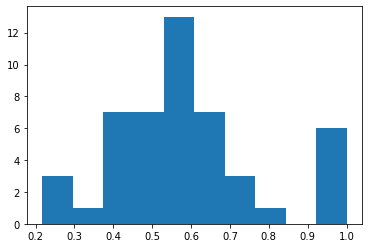

In [26]:
#histogram the out of genre scores

plt.hist(out_of_genre_scores[0])
plt.show()

From just looking at the histogram, things don't look great. The out of sample score distribution looks a kind of similar to the test score distribution so it may be harder to distinguish the Fantasy genre than we thought.

Let's check by adding these scores back into the out of sample dataframe we created, and taking a look at the high scoring rows.

In [27]:
#add the scores as a 'score' column to the out_of_sample df

out_of_genre['score'] = out_of_genre_scores[0]

In [28]:
#sort the df by your score column, from highest value to lowest

try_it_out = out_of_genre.sort_values(by='score', ascending=False)

In [29]:
#show the first 10 rows of the df

try_it_out.head(10)

,Title,Price,Description,Rating,Link,Genre,score
470,Les Fleurs du Mal,Â£29.04,Presents the first American translation of the...,Five,les-fleurs-du-mal_530/index.html,Poetry,1.000000
668,Misery,Â£34.79,Alternate cover edition here.Paul Sheldon. He'...,Two,misery_332/index.html,Horror,1.000000
389,"A la Mode: 120 Recipes in 60 Pairings: Pies, T...",Â£38.77,Are you ready to take your baking over the top...,One,a-la-mode-120-recipes-in-60-pairings-pies-tart...,Food and Drink,1.000000
89,Obsidian (Lux #1),Â£14.86,Starting over sucks.When we moved to West Virg...,Two,obsidian-lux-1_911/index.html,Young Adult,1.000000
978,"Giant Days, Vol. 1 (Giant Days #1-4)",Â£56.76,"Susan, Esther, and Daisy started at university...",Four,giant-days-vol-1-giant-days-1-4_22/index.html,Sequential Art,1.000000
625,Foundation (Foundation (Publication Order) #1),Â£32.42,For twelve thousand years the Galactic Empire ...,One,foundation-foundation-publication-order-1_375/...,Science Fiction,1.000000
927,The Mirror & the Maze (The Wrath and the Dawn ...,Â£29.38,The city of Rey is burning. With smoke billowi...,One,the-mirror-the-maze-the-wrath-and-the-dawn-15_...,Fantasy,0.770501
407,It Didn't Start with You: How Inherited Family...,Â£56.27,A groundbreaking approach to transforming trau...,Three,it-didnt-start-with-you-how-inherited-family-t...,Psychology,0.722185
814,Letter to a Christian Nation,Â£22.20,"In response to The End of Faith, Sam Harris re...",One,letter-to-a-christian-nation_186/index.html,Nonfiction,0.722185
530,How to Be a Domestic Goddess: Baking and the A...,Â£28.25,Nigella Lawson's How to Be a Domestic Goddess ...,Two,how-to-be-a-domestic-goddess-baking-and-the-ar...,Food and Drink,0.698027


In [30]:
#show the Genre value counts of the 20 highest scoring books

try_it_out.head(20).Genre.value_counts()

Fantasy               5
Young Adult           2
Food and Drink        2
Sports and Games      1
Autobiography         1
Sequential Art        1
Historical Fiction    1
Christian             1
Science Fiction       1
Nonfiction            1
History               1
Horror                1
Psychology            1
Poetry                1
Name: Genre, dtype: int64

## Lessons learned:

If you look at the dataframe above, you'll see our scoring method performed very poorly. This is for a number of reasons:

- The vectorization we used is extremely simplistic and just uses word counts. In a real world application, a data scientist would use a far more advanced embedding method.
- Our dataset is fairly small, and it seems like the Fantasy genre doesn't have many unique words like we'd hoped.
    - We can tell this by looking at the top 10 tokens in the training set. They don't seem particularly 'fantasy-like' to me:
        - ['book', 'find', 'four', 'life', 'new', 'one', 'power', 'series', 'seven', 'world']
- There's clearly a high amount of linguistic overlap between Fantasy, Non-Fiction, Young Adult, and Sequential Art book descriptions. You can tell this by looking at the highest scoring books in our out of sample test we ran. 14 out of the top 20 scoring books fall into one of those genres.

### So - how do we improve on this?
- Experiment with different numbers of features to look for. We started with 10, but you should expreriment toggling it up and down. Keep in mind that when you add tokens, even though it might make finding the genre easier, you also run the risk of catching other erroneous genres. This is a double edged sword.
- Turn the above steps into a sklearn pipeline so that you can easily run a few dozen attempts, and so that the data scientist you're likely building this pipeline for can easily grid search on it.
- Use a better vectorization method. There are lot's of better ways to do this that are more likely to be used in the real world:
    - TF-IDF stands for Term Frequency - Inverse Document Frequency. This method lowers the value given to a word if it appears many times in the overall dataset. So for example, in our book descriptions we're looking at we're specifically looking for words that are common to *only* the Fantasy genre. Words that are generally common like 'book' or aren't particularly helpful.
    
    - Use something more advanced than word frequency based methods

- Lemmatize the words. This is cutting the words down to just their stems so that words with similar roots are grouped together.
 